[View in Colaboratory](https://colab.research.google.com/github/timdellinger/Arlington-Tennis-Reservation-Data/blob/master/arlington_tennis_data.ipynb)

Arlington County VA makes its tennis court reservation data available through an open data initiative.  Let's have a look at it and see what can be learned...

I'll gratuitously comment a bit, in order to demonstrate my apporach to a dataset, and how I think as a data scientist.

Disclosure: I'm advocating that the county convert an existing set of tennis courts into pickleball courts!  The targeted location is the Walter Reed Community Center.


tl;dr:

Data science is mostly data munging, and there wasn't really a call for ai / machine learning, but some nice visualizations were made and insights gleaned:



*   Out of the 84 reservable courts in Arlington, the Walter Reed courts rank number 48, 49, and 50 in popularity
*   Courts at facilities with 6+ courts get the lions' share of the reservations.  (Walter Reed has only 3 courts.)
*   Overall reservations are declining every year
*   Walter Reed is thus an ideal candidate for conversion to pickleball courts




Tim Dellinger

The data can be found at Arlington County's Open Data Portal at the following URL:
https://data.arlingtonva.us/dataviews/244537/tennis-court-reservation/

It's accompanied by the following descriptive note:

Tennis Court reservation data beginning July 1, 2016 through the current date.  Due to the dynamic nature of reservation data, future reservations are not shown and data is subject to change.  Questions about Department of Parks and Recreation data sets should be directed to dpr@arlingtonva.us.


I'll export the data from the Arlington County website as a .csv, and rename the file tennisdata.csv on my local hard drive.

In [0]:
import pandas as pd
from google.colab import files
import numpy as np
import seaborn as sns
import matplotlib

Google CoLab likes to read in files like so:

In [3]:
uploaded = files.upload()

Saving tennisdata.csv to tennisdata.csv


In [4]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "tennisdata.csv" with length 16235610 bytes


In [0]:
df = pd.read_csv('tennisdata.csv')

Okay, let's see if it woked... what have we got?

In [5]:
df.shape

(46288, 25)

In [6]:
df.columns

Index(['ParkFacilityReservationKey', 'LocationName', 'FacilityName',
       'StreetAddressText', 'CityName', 'ZipCode', 'ReservationBeginDate',
       'ReservationBeginTime', 'ReservationEndDate', 'ReservationEndTime',
       'TransactionDate', 'TransactionTime', 'LatitudeAndLongitudeCrd',
       'ReservationDsc', 'FacilityLocationCode', 'FacilitySpaceCode',
       'CustomerName', 'HouseholdNbr', 'HeadCnt', 'ReservationPurposeDsc',
       'ComboKeyCode', 'FacilityParentCode', 'FacilityChildCodeList',
       'FacilitySiblingCodeList', 'ReservationFacilityTypeCode'],
      dtype='object')

Let's peek at a random row...

In [7]:
df[16:17]

,ParkFacilityReservationKey,LocationName,FacilityName,StreetAddressText,CityName,ZipCode,ReservationBeginDate,ReservationBeginTime,ReservationEndDate,ReservationEndTime,...,FacilitySpaceCode,CustomerName,HouseholdNbr,HeadCnt,ReservationPurposeDsc,ComboKeyCode,FacilityParentCode,FacilityChildCodeList,FacilitySiblingCodeList,ReservationFacilityTypeCode
16,102347,Maury Park,Tennis Court #1,3550 Wilson Blvd,Arlington,22201.0,2016-11-06,11:00:00,2016-11-06,12:15:00,...,CRT 1,DPR,182137,4,140602-L (Tennis 2),TENIS_MAURY_CRT 1,TENIS_MAURY_ALL,NaN,NaN,TENIS


Ususally worth a check for missing data, just to see where there might be issues.

In [8]:
df.isnull().sum()

ParkFacilityReservationKey         0
LocationName                       0
FacilityName                       0
StreetAddressText                  0
CityName                           0
ZipCode                         3075
ReservationBeginDate               0
ReservationBeginTime               0
ReservationEndDate                 0
ReservationEndTime                 0
TransactionDate                    0
TransactionTime                    0
LatitudeAndLongitudeCrd            0
ReservationDsc                     0
FacilityLocationCode               0
FacilitySpaceCode                  0
CustomerName                       0
HouseholdNbr                       0
HeadCnt                            0
ReservationPurposeDsc           3309
ComboKeyCode                       0
FacilityParentCode             19758
FacilityChildCodeList          26530
FacilitySiblingCodeList        46288
ReservationFacilityTypeCode        0
dtype: int64

Let's convert the reservation start and end times to datetime timestamps... pandas likes that format.  I'll just go ahead and make new columns.

In [0]:
df['start_datetime'] = df["ReservationBeginDate"].map(str) + str(" ") + df["ReservationBeginTime"].map(str)
df['end_datetime'] = df["ReservationEndDate"].map(str) + str(" ") + df["ReservationEndTime"].map(str)

Having a peek at one to see if it worked...

In [7]:
df.start_datetime[2]

'2016-11-06 10:00:00'

Okay, looks like somthing that can convert to datetime timestamps... converting the format of the columns.

In [0]:
df['start_datetime'] = pd.to_datetime(df.start_datetime)
df['end_datetime'] = pd.to_datetime(df.end_datetime)


Let's make sure it worked, and the usual datetime methods run smoothly...

In [9]:
df.start_datetime[2].weekday_name

'Sunday'

This'll tell us the first and last reservations in the dataset:

In [10]:
df.start_datetime.describe()

count                   46288
unique                   7701
top       2018-05-12 10:00:00
freq                       58
first     2016-01-03 10:30:00
last      2018-10-01 20:45:00
Name: start_datetime, dtype: object

Adding day of the week as a column since it'll be useful later


In [0]:
df['day_of_the_week'] = df.start_datetime.dt.weekday_name

One more column which also might be useful later: length of the reservation

In [0]:
df['reservation_length'] = df.end_datetime - df.start_datetime

Looking at basic stats on reservation length:

In [15]:
df.reservation_length.describe()

count                     46288
mean     0 days 02:13:29.879450
std      0 days 02:20:07.064045
min             0 days 00:30:00
25%             0 days 01:00:00
50%             0 days 01:15:00
75%             0 days 03:00:00
max             1 days 02:00:00
Name: reservation_length, dtype: object

 I'm thinking that the "max" of 26 hours might be a typo, with the intended reservation being 2 hours.  Let's have a peek a historgram, and recall that df.hist() will thow a Type Error unless we convert to, say, hours.

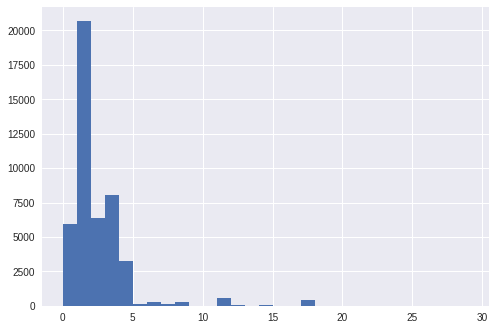

In [16]:
(df.reservation_length.astype('timedelta64[h]')).hist(bins=range(0,30,1))

The plot isn't showing showing the 26 hour reservation... maybe a log scale plot will reveal it.  Good thing we looked at the descriptive stats and not just the historgram!

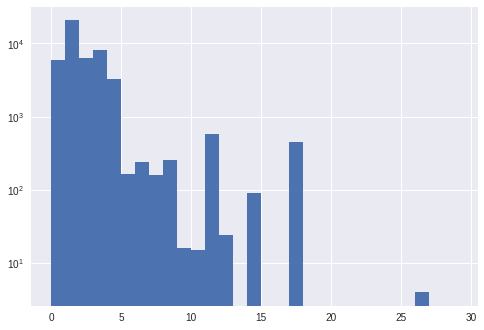

In [17]:
(df.reservation_length.astype('timedelta64[h]')).hist(bins=range(0,30,1), log=True)

Okay, not very many reservations over a day in length... those aren't really going to effect any analysis we might do very much.  Looks like most reservations are for a single play session (likely league play), an order of magnitude fewer reservations for all-day-ish, which are likely camps.  Or perhaps maintainence.

Nexy let's take a look at which day of the week the courts are used... let's make a heatmap by location and see what turns up.  Creating a new dataframe to use as input to feed into sns.heatmap

In [0]:
df_heat_1 = df.groupby(['day_of_the_week','LocationName'])['start_datetime'].count().unstack(fill_value=0)

The days are going to be in alphabetical order, so let's reorder.  I tend to just make day_of_the_week (which is the index) into an ordered Categorical, and sort the index.



In [0]:
df_heat_1.index = pd.Categorical(df_heat_1.index,categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)


In [0]:
df_heat_1 = df_heat_1.sort_index()

In [21]:
df_heat_1

LocationName,Barcroft Park,Bluemont Park,Bon Air Park,Drew Center,Fort Scott Park,Glebe Park,Greenbrier Park,Gunston Center,Hayes Park,Jamestown Park,...,Marcey Road Park,Maury Park,Quincy Park,Stratford Park,Thomas Jefferson Center,Towers Park,Tuckahoe Park,Virginia Highlands Park,Wakefield High School,Walter Reed Center
Monday,54,1634,42,0,18,44,450,38,1327,29,...,839,28,732,0,43,125,305,164,582,488
Tuesday,886,1642,163,0,152,336,470,72,206,3,...,128,24,1014,3,73,94,288,196,510,70
Wednesday,152,1848,150,0,254,454,465,42,1207,12,...,146,54,1486,0,27,127,1111,174,502,282
Thursday,120,1874,0,0,18,60,466,158,170,6,...,418,83,950,0,97,474,333,538,682,382
Friday,6,1518,8,0,6,48,451,44,75,8,...,68,26,612,0,21,10,1025,94,458,44
Saturday,126,148,20,15,104,60,532,124,46,11,...,92,241,1656,0,104,206,20,670,140,114
Sunday,13,132,54,0,76,22,1232,84,44,7,...,102,662,432,0,92,180,22,406,210,110


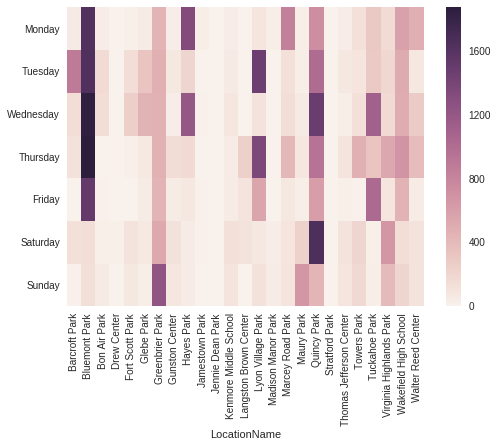

In [22]:
sns.heatmap(df_heat_1)

So that's number of reservations per park.  Bluemont is getting the lion's share of the reservations... Walter Reed barely shows up in comparison.

To be fair, Bluemont has more courts, so we might look at reservations per court.

Having a peek at the nomenclature of one location, to see if we can extract the number of courts per location...

In [23]:
df[df.LocationName=='Bluemont Park'].FacilityName.value_counts()

Tennis Court 1-9    4074
Tennis Court #1      761
Tennis Court #2      692
Tennis Court #3      690
Tennis Court #4      665
Tennis Court #5      512
Tennis Court #6      417
Tennis Court #7      403
Tennis Court #8      389
Tennis Court #9      193
Name: FacilityName, dtype: int64

Okay, there's an option to reserve all courts, but we don't know if that option has been used at all locations.  Let's look at all of them:

In [24]:
df.FacilityName.value_counts()

Tennis Court #1      9622
Tennis Court #2      6688
Tennis Courts 1-6    5889
Tennis Courts 1-2    5137
Tennis Court 1-9     4074
Tennis Court #3      3109
Tennis Courts 1-3    2593
Tennis Court #4      2360
Tennis Court #5      2231
Tennis Court #6      1365
Tennis Courts 1-7    1068
Tennis Courts 1-4     997
Tennis Court #7       573
Tennis Court #8       389
Tennis Court #9       193
Name: FacilityName, dtype: int64

A heatmap will tell us visually if they all have the "all courts" option, and if it's been used for reservations.  Let's omit the 'fill_vaule=0' this time so that zeros show up as the background color.

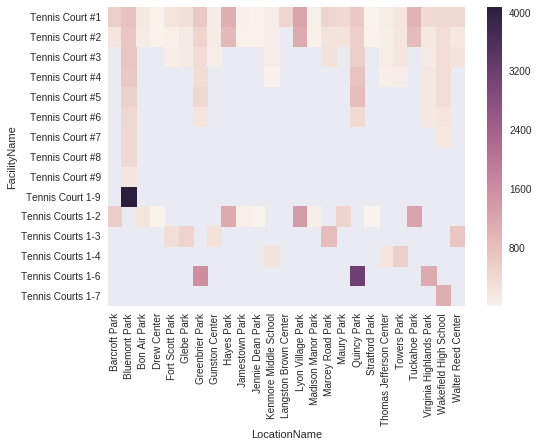

In [25]:
df_heat_2 = df.groupby(['FacilityName','LocationName'])['start_datetime'].count().unstack()
sns.heatmap(df_heat_2)

Okay, every court has at least one "reserve all courts" reservation in the dataset except 'Langston Brown Center', which only has one court... we'll just code that one by hand at the end.

We also see that Bluemont and Quincy "all courts" are by far the most common reservation.

We'll need to know how many courts are at each location. There are many ways to pull the values out of this dataframe.  Let's see if we can count non-empty values.

In [26]:
df_heat_2['Barcroft Park'].notnull().sum()

3

Okay, looks like that'll work.  Applyling to the whole dataframe, and subtracting 1 (the "reserve all courts" option).

In [27]:
number_of_courts = df_heat_2.notnull().sum(axis=0) - 1
number_of_courts['Langston Brown Center'] = 1
number_of_courts

LocationName
Barcroft Park              2
Bluemont Park              9
Bon Air Park               2
Drew Center                2
Fort Scott Park            3
Glebe Park                 3
Greenbrier Park            6
Gunston Center             3
Hayes Park                 2
Jamestown Park             2
Jennie Dean Park           2
Kenmore Middle School      4
Langston Brown Center      1
Lyon Village Park          2
Madison Manor Park         2
Marcey Road Park           3
Maury Park                 2
Quincy Park                6
Stratford Park             2
Thomas Jefferson Center    4
Towers Park                4
Tuckahoe Park              2
Virginia Highlands Park    6
Wakefield High School      7
Walter Reed Center         3
dtype: int64

Although this is a useful intermendate for calculating reservations per court, it also lets us calculate the total number of reservable courts in Arlington:

In [28]:
number_of_courts.sum()

84

The beauty of matrix math:

In [29]:
df_heat_1 / number_of_courts

LocationName,Barcroft Park,Bluemont Park,Bon Air Park,Drew Center,Fort Scott Park,Glebe Park,Greenbrier Park,Gunston Center,Hayes Park,Jamestown Park,...,Marcey Road Park,Maury Park,Quincy Park,Stratford Park,Thomas Jefferson Center,Towers Park,Tuckahoe Park,Virginia Highlands Park,Wakefield High School,Walter Reed Center
Monday,27.0,181.555556,21.0,0.0,6.000000,14.666667,75.000000,12.666667,663.5,14.5,...,279.666667,14.0,122.000000,0.0,10.75,31.25,152.5,27.333333,83.142857,162.666667
Tuesday,443.0,182.444444,81.5,0.0,50.666667,112.000000,78.333333,24.000000,103.0,1.5,...,42.666667,12.0,169.000000,1.5,18.25,23.50,144.0,32.666667,72.857143,23.333333
Wednesday,76.0,205.333333,75.0,0.0,84.666667,151.333333,77.500000,14.000000,603.5,6.0,...,48.666667,27.0,247.666667,0.0,6.75,31.75,555.5,29.000000,71.714286,94.000000
Thursday,60.0,208.222222,0.0,0.0,6.000000,20.000000,77.666667,52.666667,85.0,3.0,...,139.333333,41.5,158.333333,0.0,24.25,118.50,166.5,89.666667,97.428571,127.333333
Friday,3.0,168.666667,4.0,0.0,2.000000,16.000000,75.166667,14.666667,37.5,4.0,...,22.666667,13.0,102.000000,0.0,5.25,2.50,512.5,15.666667,65.428571,14.666667
Saturday,63.0,16.444444,10.0,7.5,34.666667,20.000000,88.666667,41.333333,23.0,5.5,...,30.666667,120.5,276.000000,0.0,26.00,51.50,10.0,111.666667,20.000000,38.000000
Sunday,6.5,14.666667,27.0,0.0,25.333333,7.333333,205.333333,28.000000,22.0,3.5,...,34.000000,331.0,72.000000,0.0,23.00,45.00,11.0,67.666667,30.000000,36.666667


Looks like it's working... but wait, it just occurred to me that we need to count a reservation of courts 1-6 as 6 reservations (not just one reservation) when calculating reservations per court.

Hmmm... okay, here's how I'll tackle it.  I'll re-run the whole groupby/count/unstack twice: once on the rows where there's just one court being reserved, and once on the rows where all courts are being reserved.

I.e.: choose all rows where column 'Facility Name' contains '#' gives us single court reservations.

And choose all rows where column 'Facility Name' contains '-' gives us reservations where  all courts are reserved at once.

(Let's make sure our selection works first.)

In [30]:
df[df['FacilityName'].str.contains("#")].FacilityName.value_counts()

Tennis Court #1    9622
Tennis Court #2    6688
Tennis Court #3    3109
Tennis Court #4    2360
Tennis Court #5    2231
Tennis Court #6    1365
Tennis Court #7     573
Tennis Court #8     389
Tennis Court #9     193
Name: FacilityName, dtype: int64

In [0]:
df_heat_1_single_courts = df[df['FacilityName'].str.contains("#")].groupby(['day_of_the_week','LocationName'])['start_datetime'].count().unstack(fill_value=0)

In [32]:
df_heat_1_single_courts

LocationName,Barcroft Park,Bluemont Park,Bon Air Park,Drew Center,Fort Scott Park,Glebe Park,Greenbrier Park,Gunston Center,Hayes Park,Jamestown Park,...,Marcey Road Park,Maury Park,Quincy Park,Stratford Park,Thomas Jefferson Center,Towers Park,Tuckahoe Park,Virginia Highlands Park,Wakefield High School,Walter Reed Center
day_of_the_week,,,,,,,,,,,,,,,,,,,,,
Friday,3,807,4,0,3,28,303,24,43,5,...,34,14,361,0,15,5,605,47,307,27
Monday,27,869,21,0,9,26,300,21,863,15,...,454,15,413,0,26,85,170,82,393,249
Saturday,71,74,10,8,52,30,266,64,23,6,...,46,141,828,0,55,103,10,335,73,58
Sunday,7,66,27,0,38,11,684,44,22,4,...,51,384,226,0,49,90,11,203,120,56
Thursday,60,1025,0,0,9,34,313,81,97,4,...,241,50,525,0,56,246,182,267,452,215
Tuesday,530,897,92,0,76,172,310,40,121,2,...,64,13,560,2,44,47,160,98,339,49
Wednesday,84,984,85,0,127,231,305,23,771,7,...,73,28,788,0,18,74,710,87,332,144


In [33]:
df[df['FacilityName'].str.contains("-")].FacilityName.value_counts()

Tennis Courts 1-6    5889
Tennis Courts 1-2    5137
Tennis Court 1-9     4074
Tennis Courts 1-3    2593
Tennis Courts 1-7    1068
Tennis Courts 1-4     997
Name: FacilityName, dtype: int64

In [0]:
df_heat_1_all_courts_at_once = df[df['FacilityName'].str.contains("-")].groupby(['day_of_the_week','LocationName'])['start_datetime'].count().unstack(fill_value=0)

Oh, yes, and let's add a value for 'Langston Brown Center' by hand since none of the datapoints contains "-", thus there will be no entry.

In [0]:
df_heat_1_all_courts_at_once['Langston Brown Center'] = 0

In [36]:
df_heat_1_all_courts_at_once

LocationName,Barcroft Park,Bluemont Park,Bon Air Park,Drew Center,Fort Scott Park,Glebe Park,Greenbrier Park,Gunston Center,Hayes Park,Jamestown Park,...,Maury Park,Quincy Park,Stratford Park,Thomas Jefferson Center,Towers Park,Tuckahoe Park,Virginia Highlands Park,Wakefield High School,Walter Reed Center,Langston Brown Center
day_of_the_week,,,,,,,,,,,,,,,,,,,,,
Friday,3,711,4,0,3,20,148,20,32,3,...,12,251,0,6,5,420,47,151,17,0
Monday,27,765,21,0,9,18,150,17,464,14,...,13,319,0,17,40,135,82,189,239,0
Saturday,55,74,10,7,52,30,266,60,23,5,...,100,828,0,49,103,10,335,67,56,0
Sunday,6,66,27,0,38,11,548,40,22,3,...,278,206,0,43,90,11,203,90,54,0
Thursday,60,849,0,0,9,26,153,77,73,2,...,33,425,0,41,228,151,271,230,167,0
Tuesday,356,745,71,0,76,164,160,32,85,1,...,11,454,1,29,47,128,98,171,21,0
Wednesday,68,864,65,0,127,223,160,19,436,5,...,26,698,0,9,53,401,87,170,138,0


Looks good (although the weekdays are out of order).  More of that convenient matrix math, and then the same trick with the index we use before to get the days in chronological order:

In [0]:
df_for_heatmap_3 = df_heat_1_single_courts + df_heat_1_all_courts_at_once * number_of_courts
df_for_heatmap_3.index = pd.Categorical(df_for_heatmap_3.index,categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
df_for_heatmap_3 = df_for_heatmap_3.sort_index()

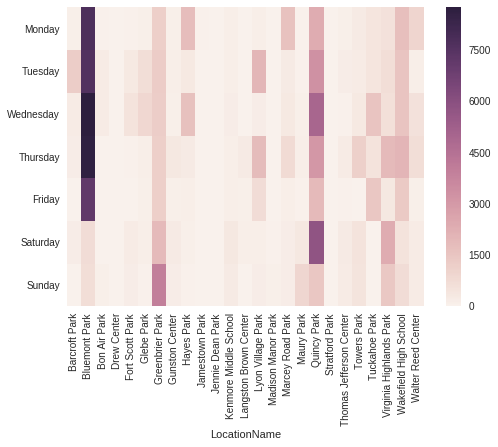

In [38]:
sns.heatmap(df_for_heatmap_3)

Now we're looking at number of reservations per court.

Okay, 'Bluemont Park' courts on weeknights is by far the most reserved!

If I were really fancy, I'd convert to number of hours, since the reservation lengths aren't all the same, but this tells the story well enough.

Showing actual numbers, and barplots:

In [39]:
df_for_heatmap_3.sum() # number of reservations per court

LocationName
Barcroft Park               1932
Bluemont Park              41388
Bon Air Park                 635
Drew Center                   22
Fort Scott Park             1256
Glebe Park                  2008
Greenbrier Park            11991
Gunston Center              1092
Hayes Park                  4210
Jamestown Park               109
Jennie Dean Park              14
Kenmore Middle School       1221
Langston Brown Center        453
Lyon Village Park           5163
Madison Manor Park           182
Marcey Road Park            3453
Maury Park                  1591
Quincy Park                22787
Stratford Park                 4
Thomas Jefferson Center     1039
Towers Park                 2914
Tuckahoe Park               4360
Virginia Highlands Park     7857
Wakefield High School       9492
Walter Reed Center          2874
dtype: int64

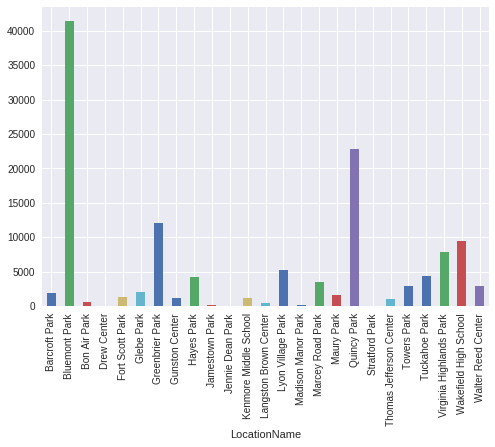

In [40]:
df_for_heatmap_3.sum().plot.bar() # number of resrevations per court

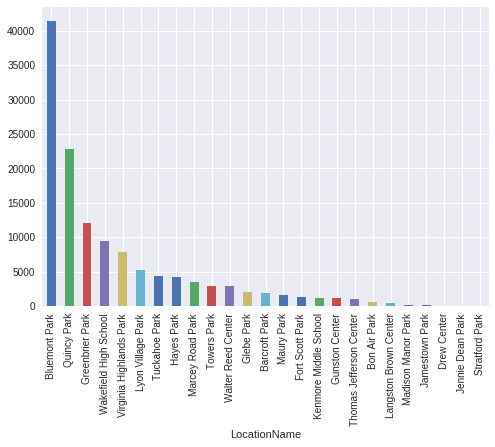

In [41]:
df_for_heatmap_3.sum().sort_values(ascending=False).plot.bar() # number of resrevations per court, sorted

So 'Walter Reed Center' is 11th out of 24 locations, and of the 84 reservable courts... 

let's see how many courts are more popular...

Grabbing the top 10 locations, and using those to subset our number_of_courts calculation from earlier...

In [42]:
top_10 = df_for_heatmap_3.sum().sort_values(ascending=False)[0:10]
top_10

LocationName
Bluemont Park              41388
Quincy Park                22787
Greenbrier Park            11991
Wakefield High School       9492
Virginia Highlands Park     7857
Lyon Village Park           5163
Tuckahoe Park               4360
Hayes Park                  4210
Marcey Road Park            3453
Towers Park                 2914
dtype: int64

In [43]:
number_of_courts[top_10.index.values]

LocationName
Bluemont Park              9
Quincy Park                6
Greenbrier Park            6
Wakefield High School      7
Virginia Highlands Park    6
Lyon Village Park          2
Tuckahoe Park              2
Hayes Park                 2
Marcey Road Park           3
Towers Park                4
dtype: int64

In [44]:
number_of_courts[top_10.index.values].sum()

47

So out of the 84 reservable courts in Arlington, the Walter Reed courts rank number 48, 49, and 50 in popularity.

Just for fun, let's see if larger facilities get more reservations...

In [45]:
sns.scatterplot(x = number_of_courts.values, y=df_for_heatmap_3.sum().values)

AttributeError: ignored

In [173]:
sns.__version__

'0.7.1'

If Google Colab isn't installing the latest version (0.9.0) by default, that's not a dragon I'm looking to slay right now.

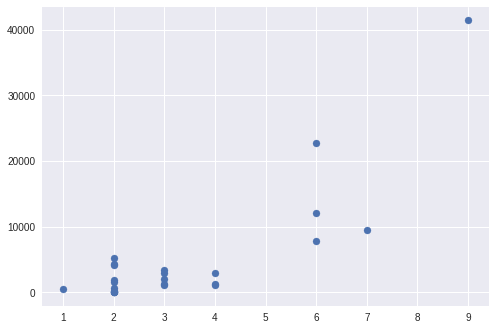

In [46]:
matplotlib.pyplot.scatter(x = number_of_courts.values, y = df_for_heatmap_3.sum().values)

So that's number of courts at a facility on the x-axis, and number of reservations per court on the y-axis.  Courts at facilities with 6+ courts get the lions' share of the reservations.

Seasonality?

I'll be a little lazy and create a new column for 'month' instead of trying to fiddle with the groupby syntax to see if it can accept something that's not a column.

In [0]:
df['month'] = df.start_datetime.dt.month

In [0]:
df_heat_4 = df.groupby(['day_of_the_week','month'])['start_datetime'].count().unstack(fill_value=0)
df_heat_4.index = pd.Categorical(df_heat_4.index,categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
df_heat_4 = df_heat_4.sort_index()



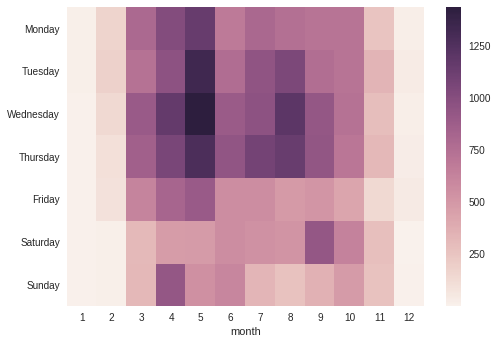

In [49]:
sns.heatmap(df_heat_4)


Wow, reservations in May are huge.

Okay, let's have a peek at why people are reserving 'Walter Reed Center':

In [0]:
wr_df = df[ df['LocationName']=='Walter Reed Center']

In [51]:
wr_df.ReservationPurposeDsc.value_counts()

ACTA                                                                               84
First Serve Tennis- Little Shots & Fun and Fundamentals                            60
55+/Pickleball                                                                     48
Private Reservation                                                                44
340604-J (Tennis 3)                                                                44
140605-F (Tennis 4)                                                                38
110602-W (Little Shots)                                                            38
ACTA Spring                                                                        32
Tennis Court Maintenance                                                           32
440604-N (Tennis 3)                                                                30
ACTA - Fall                                                                        28
Pickleball                                            

In [52]:
total_reservations_at_wr = wr_df.ReservationPurposeDsc.value_counts().sum()
total_reservations_at_wr 

1451

There's some pickleball in there!  How much?  Uppercase 'P' and lowercase 'p' are used, so let's just omit the first letter.

In [53]:
wr_df[wr_df.ReservationPurposeDsc.str.contains('ickle', na = False)].ReservationPurposeDsc.value_counts()

55+/Pickleball                                          48
Pickleball                                              24
OSAP Program - Pickleball                                8
OSAP Pickleball                                          4
osap pickleball                                          4
OSAP-55+-Pickleball Social Mixer                         4
OSAP Program - Pickleball Level II (Fee Based Class)     4
WR OSAP Pickleball                                       4
OSAP Program - Pickleball Friendly                       4
Name: ReservationPurposeDsc, dtype: int64

In [54]:
pickleball_reservations_at_wr = wr_df[wr_df.ReservationPurposeDsc.str.contains('ickle', na = False)].ReservationPurposeDsc.value_counts().sum()
pickleball_reservations_at_wr

104

So as a fraction...

In [55]:
pickleball_reservations_at_wr/total_reservations_at_wr

0.07167470709855273

That's les than 10% of reservations.  Non-zero, though!

One last plot of usage over time for 'Walter Reed Center'.  I'll similartly be lazy and make a new column for year so that I can use groupby() easily.

I'll add the column to the larger dataframe ('df'), then update wr_df so that it has the new column.

In [0]:
df['year'] = df.start_datetime.dt.year

In [0]:
wr_df = df[ df['LocationName']=='Walter Reed Center']

Now some groupby() to get what we're interested in: reservations broken down by month, with each year in a different column

In [0]:
wr_df2 = wr_df.groupby(['month','year'])['start_datetime'].count().unstack(fill_value=0)

In [59]:
wr_df2

year,2016,2017,2018
month,,,
3,30,24,22
4,78,52,60
5,80,62,50
6,78,62,38
7,60,68,30
8,122,62,40
9,86,74,62
10,82,58,10
11,64,36,0


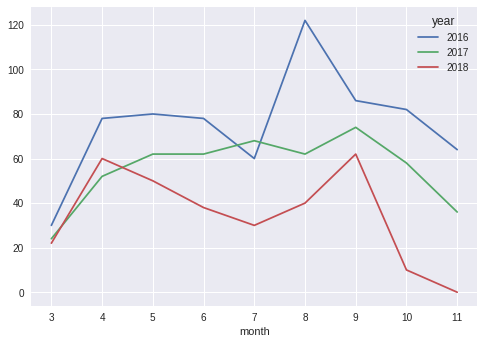

In [60]:
wr_df2.plot()

So we can see that reservations at 'Walter Reed Center' are falling year-over-year.

Maybe have a look at all reservations at all courts across the county, combined.  Basically the same code: 

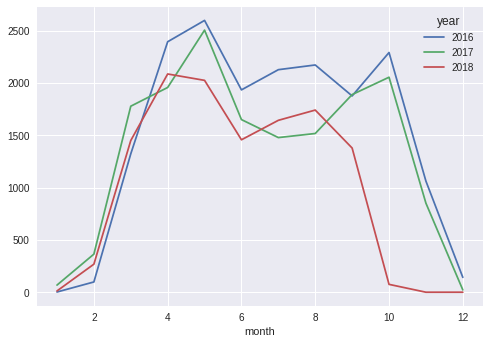

In [61]:
df.groupby(['month','year'])['start_datetime'].count().unstack(fill_value=0).plot()

Also falling year-over-year!

Summary:


*   Out of the 84 reservable courts in Arlington, the Walter Reed courts rank number 48, 49, and 50 in popularity
*   Courts at facilities with 6+ courts get the lions' share of the reservations.  (Walter Reed has only 3 courts.)
*   Overall reservations are declining every year
*   Walter Reed is thus an ideal candidate for conversion to pickleball courts
